# Cal-CRAI Index: Society & Economy Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Outlier handling
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [89]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# Society & Economy usage:
prefix = 'society_'  # You can change this to the prefix you need

# domain-specific
domain_prefix = 'society_'  # You can change this to any prefix you need

input_folder = r'C:/Users/jesse/eagle/carb-climate-index/scripts/index_method/aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'C:/Users/jesse/eagle/carb-climate-index/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
merged_output_file = 'concatenate_society_economy_metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within society_ domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_society_economy_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_population_ambulatory_disabilities',
  'percent_total_pop_american_indian_alaska_native',
  'percent_population_cognitive_disabilities',
  'est_gini_index',
  'hachman_index',
  'percent_children_household_financial_assistance',
  'percent_1miurban_10mirural',
  'avg_hpsscore_mental_shortage_metric',
  'real_percent_total_pop_over_65',
  'avg_hpsscore_primary_care_metric',
  'percent_total_pop_under_5',
  'asthma_related_ed_visits_per_10000_people_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'education_percent_2019',
  'avg_percent_population_homeless',
  'housing_burden_percent_2019',
  'sum_imp_water_bodies',
  'linguistic_isolation_percent_2019',
  'low_birth_weight_percent_2019',
  'Percent of households without air conditioning',
  'Percent of population employed and aged > 16 working outdoors',
  'poverty_percent_2019',
  'unemployment_percent_2019',
  'Number of Violent Crimes per 10,000 Population',
  'percent_population_

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_society_df = pd.read_csv('concatenate_society_economy_metrics.csv')
processed_society_df

,GEOID,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236,15.885023,58.256725,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500,0.000000,30.832177,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000,3.184713,30.832177,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836,14.240170,30.832177,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078,4.435484,30.832177,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265,13.194444,0.000000,...,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018,44.331984,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


### 1b) Handle outliers for each column / metric:
We set a max and min fence based based on each metrics 90th and 10th percentiles with the `handle_outliers` function
* Max fence = 3 x 90th percentile
* Min fence = -3 x 10th percentile

Note: Fencing/outlier handling is not conducted for demographic based metrics (all metrics within vulnerable indicator within Society and Economy domain)

In [6]:
# handle outliers
no_outlier_society_economy_metrics = handle_outliers(processed_society_df, domain_prefix, summary_stats=True)

For column blood and organ banks per 10000 people:
  Q1 (10th percentile): 0.0271720260972215
  Q3 (90th percentile): 0.0661606844543342
  IQR: 0.03898865835711271
  Max fence: 0.19848205336300262
  Min fence: -0.0815160782916645
For column est_gini_index:
  Q1 (10th percentile): 0.3445
  Q3 (90th percentile): 0.5091
  IQR: 0.16460000000000002
  Max fence: 1.5272999999999999
  Min fence: -1.0334999999999999
For column hachman_index:
  Q1 (10th percentile): 0.7127263993671944
  Q3 (90th percentile): 0.9503871439131188
  IQR: 0.23766074454592445
  Max fence: 2.8511614317393565
  Min fence: -2.138179198101583
For column est_median_income_dollars:
  Q1 (10th percentile): 49914.6
  Q3 (90th percentile): 158417.2
  IQR: 108502.6
  Max fence: 475251.60000000003
  Min fence: -149743.8
For column health and personal care stores per 10000 people:
  Q1 (10th percentile): 1.8406258816081909
  Q3 (90th percentile): 3.327063639904233
  IQR: 1.4864377582960422
  Max fence: 9.981190919712699
  Min fen

In [7]:
no_outlier_society_economy_metrics

,GEOID,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236.0,15.885023,58.256725,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500.0,0.000000,30.832177,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000.0,3.184713,30.832177,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836.0,14.240170,30.832177,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078.0,4.435484,30.832177,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265.0,13.194444,0.000000,...,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321.0,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534.0,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018.0,44.331984,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


### 1c) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [8]:
# standardizing our df
columns_to_process = [col for col in no_outlier_society_economy_metrics.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(no_outlier_society_economy_metrics, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [16]:
# this will show the standardized columns as well as their max and min column counterparts used in the process
#min_max_metrics

Isolate for GEOID and standardized columns exclusively

In [9]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]

In [11]:
min_max_standardized_society_economy_metrics_df.head()

,GEOID,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,...,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.046803,0.000000,0.13134,0.000876,0.503770,0.962333,0.936422,0.158850,0.582567,...,0.134367,0.054054,0.012,0.280817,0.643066,0.012265,0.103753,0.109878,0.797158,0.004818
1,6001400200,0.040056,0.005464,0.13134,0.000323,0.483284,0.962333,0.900035,0.000000,0.308322,...,0.041344,0.000000,0.000,0.295405,0.643066,0.021277,0.105960,0.068337,0.797158,0.014672
2,6001400300,0.022958,0.006831,0.13134,0.000598,0.558828,0.962333,0.643873,0.031847,0.308322,...,0.104651,0.000000,0.080,0.275711,0.643066,0.015369,0.102649,0.088838,0.797158,0.028964
3,6001400400,0.036466,0.006831,0.13134,0.000537,0.622564,0.962333,0.622364,0.142402,0.308322,...,0.180879,0.000000,0.009,0.323851,0.643066,0.028617,0.221854,0.056948,0.797158,0.039271
4,6001400500,0.033679,0.001366,0.13134,0.001054,0.552568,0.962333,0.356797,0.044355,0.308322,...,0.180879,0.000000,0.017,0.265500,0.643066,0.050283,0.230684,0.086560,0.797158,0.078438


### 1d) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

Some metrics indicate a communities resistance rather than vulnerablity. For example, number of emergency personel per 10,000 people represents a communities ability to respond to emergencies. For this metric, the higher the number, the more resilient. So we identify these 'resilient' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate vulnerability

In [12]:
# Access the resilient column names from the dictionary
resilient_columns = metric_vulnerable_resilient_dict['resilient']

# Identify columns in the DataFrame that contain any of the resilient column names as substrings
resilient_columns_in_df = [col for col in min_max_standardized_society_economy_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in resilient_columns)]

# Subtract the standardized resiliant columns from one
min_max_standardized_society_economy_metrics_df.loc[:, resilient_columns_in_df] = (
    1 - min_max_standardized_society_economy_metrics_df.loc[:, resilient_columns_in_df]
)

In [13]:
min_max_standardized_society_economy_metrics_df

,GEOID,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,...,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.046803,0.000000,0.86866,0.000876,0.503770,0.962333,0.063578,0.158850,0.582567,...,0.134367,0.054054,0.012000,0.280817,0.643066,0.012265,0.103753,0.109878,0.797158,0.004818
1,6001400200,0.040056,0.005464,0.86866,0.000323,0.483284,0.962333,0.099965,0.000000,0.308322,...,0.041344,0.000000,0.000000,0.295405,0.643066,0.021277,0.105960,0.068337,0.797158,0.014672
2,6001400300,0.022958,0.006831,0.86866,0.000598,0.558828,0.962333,0.356127,0.031847,0.308322,...,0.104651,0.000000,0.080000,0.275711,0.643066,0.015369,0.102649,0.088838,0.797158,0.028964
3,6001400400,0.036466,0.006831,0.86866,0.000537,0.622564,0.962333,0.377636,0.142402,0.308322,...,0.180879,0.000000,0.009000,0.323851,0.643066,0.028617,0.221854,0.056948,0.797158,0.039271
4,6001400500,0.033679,0.001366,0.86866,0.001054,0.552568,0.962333,0.643203,0.044355,0.308322,...,0.180879,0.000000,0.017000,0.265500,0.643066,0.050283,0.230684,0.086560,0.797158,0.078438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.005353,0.002732,NaN,0.000092,0.507185,0.776821,0.813198,0.131944,0.000000,...,0.444444,0.000000,0.059167,0.315828,0.017253,0.080654,0.301325,0.077449,0.430398,0.025294
9125,6115041001,0.083878,0.004098,NaN,0.000635,0.617015,0.776821,0.758817,0.000000,0.376367,...,0.244473,0.081081,0.059167,0.354729,0.017253,0.158451,0.519990,0.213870,0.430398,0.048611
9126,6115041002,0.091601,0.035519,NaN,0.001645,0.595817,0.776821,0.612147,0.000000,0.376367,...,0.244473,0.081081,0.059167,0.354729,0.017253,0.158451,0.519990,0.213870,0.430398,0.271437
9127,6115041101,0.168269,0.015027,NaN,0.001594,0.481576,0.776821,0.885036,0.443320,0.376367,...,0.244473,0.081081,0.059167,0.354729,0.017253,0.158451,0.519990,0.213870,0.430398,0.130026


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [17]:
averaged_indicators_society_economy = compute_averaged_indicators(
    min_max_standardized_society_economy_metrics_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_society_economy

,GEOID,vulnerable_populations,social_services,economic_health
0,6001400100,0.166465,0.782271,0.509894
1,6001400200,0.142824,0.782271,0.515194
2,6001400300,0.138695,0.782271,0.625763
3,6001400400,0.160363,0.782271,0.654178
4,6001400500,0.151013,0.782271,0.719368
...,...,...,...,...
9124,6115040902,0.122242,0.646085,0.699068
9125,6115041001,0.192893,0.646085,0.717551
9126,6115041002,0.195635,0.646085,0.661595
9127,6115041101,0.209901,0.646085,0.714478


Sum all the non-census tract columns together to calculate the domain score

In [18]:
columns_to_sum = [col for col in averaged_indicators_society_economy.columns if col != 'GEOID']
summed_indicators_society_economy = compute_summed_indicators(
    df=averaged_indicators_society_economy, 
    columns_to_sum=columns_to_sum
)

Indicator sum min value: 0.0
Indicator sum max value: 2.093194826054311


### 2a) Min-max standardize the summed columns

In [19]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [20]:
min_max_standardized_society_economy_domain = min_max_domain[['GEOID', 'summed_indicators_society_economy_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [21]:
gdf = add_census_tracts(min_max_standardized_society_economy_domain)

Let's look at some summary statistics for this domain:

In [22]:
domain_summary_stats(gdf, domain=domain_prefix)

Median society_economy domain value: 0.7676815980409805
Mean society_economy domain value: 0.763338309868222


In [54]:
gdf

,GEOID,summed_indicators_society_economy_domain_min_max_standardized,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06001400100,0.696843,06,001,400100,4001,Census Tract 4001,G5020,S,6945856,0,+37.8676563,-122.2318813,"POLYGON ((-122.24691 37.88535, -122.24665 37.8..."
1,06001400200,0.688081,06,001,400200,4002,Census Tract 4002,G5020,S,586560,0,+37.8481378,-122.2495916,"POLYGON ((-122.25792 37.84261, -122.25773 37.8..."
2,06001400300,0.738932,06,001,400300,4003,Census Tract 4003,G5020,S,1110840,0,+37.8405841,-122.2544782,"POLYGON ((-122.26563 37.83764, -122.26556 37.8..."
3,06001400400,0.762858,06,001,400400,4004,Census Tract 4004,G5020,S,716138,0,+37.8482840,-122.2574447,"POLYGON ((-122.26183 37.84162, -122.26180 37.8..."
4,06001400500,0.789536,06,001,400500,4005,Census Tract 4005,G5020,S,591424,0,+37.8485452,-122.2647353,"POLYGON ((-122.26951 37.84858, -122.26937 37.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.701031,06,115,040902,409.02,Census Tract 409.02,G5020,S,93603063,240059,+39.1193450,-121.3995842,"POLYGON ((-121.47722 39.13333, -121.47709 39.1..."
9125,06115041001,0.743614,06,115,041001,410.01,Census Tract 410.01,G5020,S,275920634,1720985,+39.2634436,-121.5062545,"POLYGON ((-121.63637 39.24608, -121.63629 39.2..."
9126,06115041002,0.718192,06,115,041002,410.02,Census Tract 410.02,G5020,S,192476772,5206412,+39.2923343,-121.3205968,"POLYGON ((-121.46947 39.33348, -121.46900 39.3..."
9127,06115041101,0.750271,06,115,041101,411.01,Census Tract 411.01,G5020,S,464905359,16529900,+39.4752686,-121.1718725,"POLYGON ((-121.37257 39.37358, -121.37253 39.3..."


Now let's visualize the entire domain!

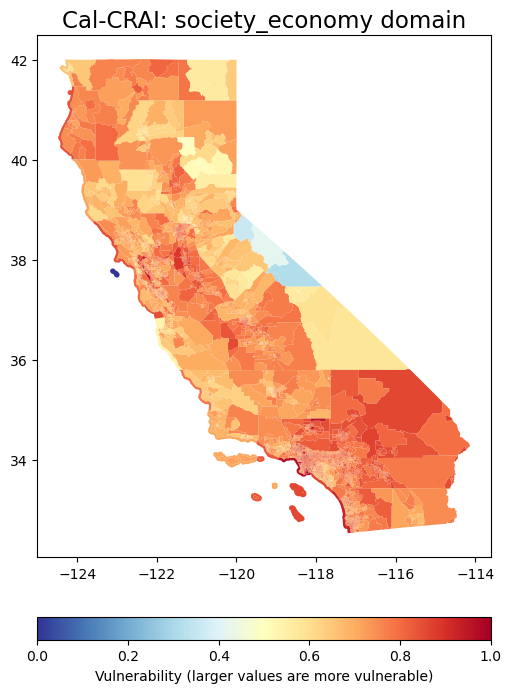

In [23]:
plot_domain(gdf, domain=domain_prefix)

We can also visualize specific areas! The following figure is an example of looking at Los Angeles and the surrounding counties. You can modify to any area of interest, just modify the county values (by the NFIP code). 
To do: optional function for folks to "look up" the NFIP code

Number of invalid geometries: 0


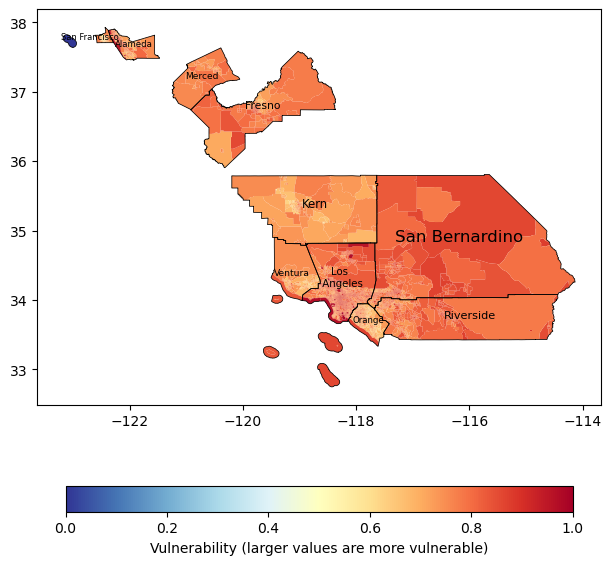

In [92]:
list_of_counties = ['037', '071', '065', '029', '111', '059', '019', '047', '001']
plot_region_domain(min_max_standardized_society_economy_domain, list_of_counties, savefig=True)

## Step 4: Export the final domain csv file

In [17]:
# set-up file for export
filename = '{}index_data.csv'.format(domain_prefix)
gdf.to_csv(filename, index=False)

# export to AWS (Cal-CRAI)
directory = '3_fair_data/domain_standardized_data'
upload_csv_aws([filename], bucket_name, directory)